# Linear Regression with Variational Inference and Markov Chain Monte Carlo Sampling

In my blog post about Bayesian linear regression I go more in depth into the topic of linear regression in general. You might want to check it out, if you are unfamiliar with it. Here we will only review the most basic intuitions.

Given a dataset $\mathcal{D}=\{x_i,y_i\}$ and a model with parameters $\boldsymbol{\theta}$ we want to find the best estimate for the true value for $y$:

$$\hat{y} = \theta_0 + \theta_1 x=\boldsymbol{\theta}^T\mathbf{x} ~,$$

where we defined $x_0=1$ and $\hat{y}$ denotes the output of our model. Since all real world data is corrupted or distorted by noise coming from different sources (e.g. limitations in measurement tools), the true observations are pertubed with noise $\epsilon$, which is assumed to be a Gaussian with zero mean and variance $\sigma^2$:

$$y_i=\boldsymbol{\theta}^T\mathbf{x}_i + \epsilon_i \quad \textrm{with} \quad \epsilon_i \sim \mathcal{N}(0,\sigma^2) ~.$$

Thus, we can model each point with a Gaussian distribution

$$p(y_i|\mathbf{x}_i,\boldsymbol{\theta},\sigma^2) = \frac{1}{\sigma\sqrt{2\pi}}\exp \left\{-\frac{1}{2\sigma^2}(y_i - \boldsymbol{\theta}^T\mathbf{x}_i)^2 \right\} ~.$$

Assuming i.i.d. data points the probability of all points called likelihood factorizes:

$$p(\mathbf{y}|\mathbf{X},\boldsymbol{\theta},\sigma^2) = \prod_i p(y_i|\mathbf{x}_i,\boldsymbol{\theta},\sigma^2) = \sum_i \log p(y_i|\mathbf{x}_i,\boldsymbol{\theta},\sigma^2) ~.$$

Derivating for $\boldsymbol{\theta}$ and $\sigma^2$ and setting the derivative to 0 yields the maximum likelihood estimate (MLE). In contrast to MLE variational inference (VI) and Markov chain Monte Carlo (MCMC) sampling provide measures for certainty in the proposed parameters by making use of Bayes' theroem:

$$p(\boldsymbol{\theta}|\mathbf{X},\mathbf{y},\sigma^2)= \frac{p(\mathbf{y}|\mathbf{X},\boldsymbol{\theta},\sigma^2)p(\boldsymbol{\theta})}{p(\mathbf{y}|\mathbf{X},\sigma^2)}~, \\\textrm{which speaks}\quad \textrm{posterior} = \frac{\textrm{likelihood } \times \textrm{ prior}}{\textrm{evidence}} ~.$$

While the likelihood is the one from above, we introduce three new terms here: the posterior, prior, and evidence. The likelihood is multiplied by a prior, a distribution over $\boldsymbol{\theta}$, that quantifies our believe in the model parameters prior to any training. We can also express zero prior knowledge by using a uniform distribution or a fairly wide Gaussian, when we assume our parameters to have Gaussian distributions. When we have computed the product of likelihood and prior, the evidence normalizes that product to obtain a valid probability distribution. The evidence can be seen as probability for seeing that particular data. After we have performed these computations, we obtain the posterior: the probability distribution of the parameters after seeing data.
For a new data point $(\mathbf{x}_∗, y_*)$ the prediction of the model is obtained by considering
the predictions made using all possible parameter setting, weighted by their posterior
probability:

$$p(y_*|\mathbf{x}_*,\mathbf{y},\mathbf{X},\sigma^2) = \int p(y_*|\mathbf{x}_*,\boldsymbol{\theta})p(\boldsymbol{\theta}|\mathbf{X},\mathbf{y},\sigma^2)d\boldsymbol{\theta} ~.$$

Problematically this integral becomes intractable for even small models that are non-linear, so that other techniques such as VI and MCMC sampling must be employed. Here we compare both methods for the linear case.

In [2]:
import matplotlib
%matplotlib inline

import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from typing import Callable

import seaborn as sns
sns.set()

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{bm}'

### Generating example data
$y = \theta_0 + \theta_1 x + \epsilon = -1 + x + \epsilon \quad \textrm{with} \quad \epsilon \sim \mathcal{N}(0,0.15)$ .

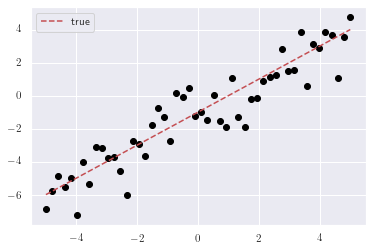

In [3]:
def model(x, weights):
    X = np.array([x**k for k in range(len(weights))]).transpose()
    return (X @ weights[:,np.newaxis]).flatten()

no_samples = 50

x = np.linspace(-5, 5, no_samples)

weights = np.array([-1, 1])
std_noise = 1.2

y_true = model(x, weights)
y_noisy = y_true + np.random.normal(0, std_noise, len(y_true))

plt.plot(x, y_true, color='r', linestyle='--', label='true')
plt.scatter(x, y_noisy, color='black')
plt.legend()
plt.show()

### MCMC Sampling

One popular technique for approximating the intractable posterior is MCMC sampling, conrtary to other methods it makes no assumption concerning the form of the distribution, such as wether it can be approximated by a multivariate Gaussian. They only assume the posterior $p(\boldsymbol{\theta}|\mathbf{X},\mathbf{y},\sigma^2)$ can be calculated up to normalization constant $Z$ meaning $p(\boldsymbol{\theta}|\mathbf{X},\mathbf{y},\sigma^2)=\tilde{p}(\boldsymbol{\theta}|\mathbf{X},\mathbf{y},\sigma^2)/Z$, where $Z$ denotes the evidence in our case.

In general, sampling methods try to find the expectation of some function $\mathbf{f}_{\boldsymbol{\theta}}(\mathbf{x})$ w.r.t. the posterior distribution for the model parameter:

$$\mathbb{E}(\mathbf{f}) = \int \mathbf{f}_{\boldsymbol{\theta}}(\mathbf{x}_*)p(\boldsymbol{\theta}|\mathbf{X},\mathbf{y},\sigma^2)d\boldsymbol{\theta} ~.$$

The integral in above equation is approximated using Monte Carlo sampling:

$$\mathbb{E}(\mathbf{f}) = \frac{1}{M} \sum_{i=1}^M \mathbf{f}_{\boldsymbol{\theta}_i}(\mathbf{x}_i) \quad \textrm{where} \quad \boldsymbol{\theta}_i \sim p(\boldsymbol{\theta}|\mathbf{X},\mathbf{y},\sigma^2) ~.$$

Similar, the variance can be denoted by

$$\textrm{Var}[\mathbf{f}] = \frac{1}{M} \mathbb{E}[(\mathbf{f}-\mathbb{E}[\mathbf{f}])^2] ~,$$

if the generated samples from the posterior $\boldsymbol{\theta}_i$ are independent. For complicated posterior distributions this is mostly impossible, but it still gives an unbiased estimate, if the number of generated samples is high enough.

To generate a set of dependent weights θi a Markov chain can be utilized that has
the posterior $p(\boldsymbol{\theta}|\mathbf{X},\mathbf{y},\sigma^2)$ as its equilibrium distribution. Markov Chains are a sequence of events, where the probability of one event depends only on the state of the previous one. So, one
samples from a proposal distribution $q(\boldsymbol{\theta}|\boldsymbol{\theta}_i)$ and maintains a record of the current state $\boldsymbol{\theta}_i$. A Markov chain is defined by giving an initial distribution for the
first state of the chain $\boldsymbol{\theta}_1$ and a transition distribution for a new state $\boldsymbol{\theta}_{i+1}$ following from the current state $\boldsymbol{\theta}_i$. A stationary distribution q is established if the distribution
given by state $\boldsymbol{\theta}_{i+1}$ is the same as with state $\boldsymbol{\theta}_i$. If the drawn samples are dependent then early drawn samples need to be discarded, since they usually are not representatives
of the equilibrium distribution referred to as burn in phase. If the samples are dependent
the chain also needs much longer to reach its equilibrium distribution.

A popular algorithm for MCMC sampling is Metropolis-Hastings. The acceptance probability Ai at time step i is given by

$$A_i(\boldsymbol{\theta}_*,\boldsymbol{\theta}_i) = \textrm{min} \left( 1, \frac{q(\boldsymbol{\theta}_i|\boldsymbol{\theta}_*)\tilde{p}(\boldsymbol{\theta}_*)}{q(\boldsymbol{\theta}_*|\boldsymbol{\theta}_i)\tilde{p}(\boldsymbol{\theta}_i)}  \right) ~,$$

where $\boldsymbol{\theta}_i$ denotes the current state and $\boldsymbol{\theta}_*$ the drawn proposal state, $\tilde{p}(\boldsymbol{\theta})$ is the prior of the model parameters. The normalization constants cancel out each other. After the acceptance probability is calculated, a random number $r$ is drawn from a Uniform distribution $r \sim \mathcal{U}(0,1)$. If $A_i > r$ the proposal state is accepted. 

In [4]:
class MCMC:
    def __init__(self, start_params: np.ndarray, model: Callable, num_iter: int = 10000, burnin_iter: int = 5000):
        self.num_iter = num_iter
        self.burnin_iter = burnin_iter
        self.start_params = start_params
        self.model = model
    
    def proposal_fct(self, params, scale_weights=0.5, scale_std_noise=0.5):
        if isinstance(scale_weights, (float, int)):
            scale_weights = [scale_weights for _ in range(len(params)-1)]
        return np.append(np.random.normal(loc=params[:-1], scale=scale_weights), np.random.normal(loc=params[-1], scale=scale_std_noise))
    
    def metropolis_hastings(self, x, y):
        self.chain = np.zeros((self.num_iter, len(self.start_params)))
        self.chain[0] = self.start_params
        
        log_post = lambda p: self.log_posterior(x, y, p, self.model)

        for i in tqdm(range(self.num_iter-1)):
            proposal = self.proposal_fct(self.chain[i])
            posterior_prob = np.exp(log_post(proposal) - log_post(self.chain[i]))
            if np.random.uniform(0, 1) < posterior_prob:
                self.chain[i+1] = proposal
            else:
                self.chain[i+1] = self.chain[i]

        self.posterior_params = self.chain[self.burnin_iter:].mean(axis=0)
        
        return self.posterior_params
    
    def posterior_pred(self, x):
        y_pred = np.array([self.model(x, c[:-1]) for c in self.chain[self.burnin_iter:]])
        return y_pred.mean(axis=0).flatten(), y_pred.std(axis=0).flatten()
    
    @staticmethod
    def log_prior(params, prior_scale_weights=1., prior_scale_noise=5.):
        if isinstance(prior_scale_weights, (float, int)):
            prior_scale_weights = [prior_scale_weights for _ in range(len(params)-1)]
        log_prior_weights = np.array([stats.norm.logpdf(w, loc=0, scale=psw) for w, psw in zip(params[:-1], prior_scale_weights)])
        log_prior_noise = stats.uniform.logpdf(params[-1], loc=0, scale=prior_scale_noise)
        return log_prior_weights.sum() + log_prior_noise
    
    @staticmethod
    def log_likelihood(x, y, params, model):
        y_pred = model(x, params[:-1])
        log_likelihoods = stats.norm.logpdf(y, loc=y_pred, scale=params[-1])
        return np.sum(log_likelihoods)
    
    def log_posterior(self, x, y, params, model):
        return self.log_likelihood(x, y, params, model) + self.log_prior(params)

## Variational Inference

Variational inference (VI) has its origin in the 18th century by the work of Euler, Lagrange and others on the calculus of variations, which works on functionals. In contrast to a function that takes a value as input and returns another value, a functional takes a function as input and returns a value. An example for this is the entropy:

$$\textrm{H}[p]=-\int p(x) \log p(x) \, dx ~,$$

which takes as input a probability distribution and returns a value. The derivative of a function describes how much the output value changes as we make infinitesimal changes to the input value. Consequently the derivative of a functional describes how much the output value changes it we make infinitesimal changes to the function. Our goal is to find the function that minimizes the functional. Since many functions (such as neural networks) are very complex because of their high number of parameters, they lend themselves to approximation by restricting the range of functions over which the optimization is performed.

In the fully Bayesian treatment of VI all parameters are given prior distributions, where $\boldsymbol{\theta}$ are our parameters (and all latent variables) and $\mathbf{X}$ are our observed variables. Our probabilistic model is given by the joint distribution $p(\mathbf{X},\boldsymbol{\theta})$. Our goal is to find approximations for the posterior the evidence from Bayes theorem. We do so by approximating our intractable posterior distribution $p(\boldsymbol{\theta}|\mathbf{X},\mathbf{y})$ with a simpler distribution $q(\boldsymbol{\theta})$ from a family of distributions $\mathcal{Q}$ e.g. the multivariate Gaussian. The optimization objective is then given by the Kullback-Leibler (KL) divergence between our approximate and the true posterior:

$$F(q):=\mathrm{KL}(q(\boldsymbol{\theta})||p(\boldsymbol{\theta}|\mathcal{D}))=\int q(\boldsymbol{\theta})\log \frac{q(\boldsymbol{\theta})}{p(\boldsymbol{\theta}|\mathcal{D})}\,\mathrm{d}\boldsymbol{\theta} \longrightarrow \underset{q(\boldsymbol{\theta}) \in \mathcal{Q}}{\min} ~.$$

Although the KL divergence is not a true distance metric because of its asymmetry it can be seen as one in this case. The KL divergence is analysed in more depth in this <a href="">post</a>. For now it is enough to now that is only zero if and only if both distributions are equal. For all other cases it is always gretaer than zero.

### Log Evidence Lower Bound

Calculating the KL divergence from above between approximate and true posterior still makes it necessary to compute the true one. By rewriting the logarithm of the evidence we are able to reformulate the problem.

\begin{equation*}
\begin{aligned}
\log p(\mathcal{D}) &= \int q(\boldsymbol{\theta}) \log p(\mathcal{D})\,d\boldsymbol{\theta} \quad\quad\quad \textrm{with} \quad \int q(\boldsymbol{\theta})\,d\boldsymbol{\theta}=1  \\
&= \int q(\boldsymbol{\theta})\log\frac{p(\mathcal{D},\boldsymbol{\theta})}{p(\boldsymbol{\theta}|\mathcal{D})}\,d\boldsymbol{\theta} \quad\quad \textrm{with} \quad p(\mathcal{D},\boldsymbol{\theta})=p(\boldsymbol{\theta}|\mathcal{D})p(\mathcal{D}) \\
&= \int q(\boldsymbol{\theta})\log \frac{p(\mathcal{D},\boldsymbol{\theta})q(\boldsymbol{\theta})}{p(\boldsymbol{\theta}|\mathcal{D})q(\boldsymbol{\theta})}\,d\boldsymbol{\theta} \\
&= \int q(\boldsymbol{\theta})\log\frac{p(\mathcal{D},\boldsymbol{\theta})}{q(\boldsymbol{\theta})}\,d\boldsymbol{\theta} + \int q(\boldsymbol{\theta})\frac{q(\boldsymbol{\theta})}{p(\boldsymbol{\theta}|\mathcal{D})}\,d\boldsymbol{\theta}
\end{aligned}
\label{eq:elbo}\tag{1}
\end{equation*}

We notice, the second term in above equation is our KL divergence from the variational objective. Because of its non-negativity the log evidence must always be greater or equal to the first term, which gives it its name, the (log) evidence lower bound.

$$
\log p(\mathcal{D}) = \textrm{ELBO}(q(\boldsymbol{\theta})) + \mathrm{KL}(q(\boldsymbol{\theta})||p(\boldsymbol{\theta}|\mathcal{D}))
$$

$$
\Longrightarrow \log p(\mathcal{D}) \geq \textrm{ELBO}(q(\boldsymbol{\theta}))
$$

Following from that minimizing the KL divergence between approximate and true posterior is the same as maximizing the ELBO w.r.t.\ $q$.

$$
\mathrm{KL}(q(\boldsymbol{\theta})||p(\boldsymbol{\theta}|\mathcal{D})) \longrightarrow \underset{q(\boldsymbol{\theta}) \in \mathcal{Q}}{\min} \Longleftrightarrow \textrm{ELBO}(q(\boldsymbol{\theta})) \longrightarrow \underset{q(\boldsymbol{\theta}) \in \mathcal{Q}}{\max}
$$

For optimization we must now restrict our family of distributions for $q(\boldsymbol{\theta})$ to only allow for tractable solutions. One way is to use a parametric distribution $q_{\boldsymbol{\omega}}(\boldsymbol{\theta})$ governed by a set of parameters $\boldsymbol{\omega}$. Hence, the ELBO becomes a function of $\boldsymbol{\omega}$, and we can exploit standard non-linear optimization techniques to determine the optimal values for the parameters. Another possibility is to use factorized distributions, which will be examined further in the following part, where we take VI to use for the simple example of linear regression.

## Mean Field Assumption

As alternative to the parametric approximation is to use a factorized distribution known as mean field approximation that originated in a framework from physics knwon as mean field theory (Parisi, 1988).

\begin{equation*}
q(\boldsymbol{\theta})=\prod_i q_i(\theta_i)
\label{eq:mean_field_approx}\tag{2}
\end{equation*}

We notice that we do not make any further assumptions about the approximating distribution e.g. as to wether is comes from a Gaussian distribution. We now search for the distribution for which the ELBO from above is the largest. In order to do so, we perform a free form (variational) optimization of $\textrm{ELBO}(q(\boldsymbol{\theta}))$ w.r.t. to all of the distributions $q_i(\theta_i)$. We therefore start by inserting Eq. $\eqref{eq:mean_field_approx}$ into Eq. $\eqref{elbo}$

$$
\begin{aligned}
\textrm{ELBO}(q(\boldsymbol{\theta})) &= \int \prod_i q_i(\theta_i) \log \frac{p(\mathcal{D},\boldsymbol{\theta})}{\prod_i q_i(\theta_i)}\,d\boldsymbol{\theta} \\
&= \int q_i(\theta_i)\log p(\mathcal{D},\boldsymbol{\theta})\,d\boldsymbol{\theta} - \int \prod_i q_i(\theta_i) \log \prod_i q_i(\theta_i)\,d\boldsymbol{\theta} ~.
\end{aligned}
$$

We now seek to optimize w.r.t. a single variational density $q_j(\theta_j)$ and must therefore dissect it from the above

$$
\begin{aligned}
\textrm{ELBO}(q(\boldsymbol{\theta})) &= \int \prod_i q_i(\theta_i)\log p(\mathcal{D},\boldsymbol{\theta})\,d\boldsymbol{\theta} - \int q_j(\theta_j)\log q_j(\theta_j)\,d\theta_j - \underbrace{\int \prod_{i \neq j} q_i(\theta_i) \log \prod_{i\neq j}q_i(\theta_i)\,d\boldsymbol{\theta}_{-j}}_{\textrm{const. w.r.t. } q_j(\theta_j)} \\
&\propto \int \prod_i q_i(\theta_i)\log p(\mathcal{D},\boldsymbol{\theta})\,d\boldsymbol{\theta} - \int q_j(\theta_j)\log q_j(\theta_j)\,d\theta_j \\
&\propto \int q_j(\theta_j) \left\{ \int \prod_{i \neq j} q_i(\theta_i) \log p(\mathcal{D},\boldsymbol{\theta})\,d\boldsymbol{\theta}_{-j} \right\}\,d\theta_j - \int q_j(\theta_j)\log q_j(\theta_j)\,d\theta_j \\
&\propto \int q_j(\theta_j)\, \mathbb{E}_{i \neq j}\left[ \log p(\mathcal{D},\boldsymbol{\theta}) \right] \,d\theta_j - \int q_j(\theta_j)\log q_j(\theta_j)\,\theta_j ~.
\end{aligned}
$$

We do now follow Bishop (2006, p. 465) and define a new distribution by the relation

$$
\log \tilde{p}(\mathcal{D},\theta_j) = \mathbb{E}_{i \neq j}\left[ \log p(\mathcal{D},\boldsymbol{\theta}) \right] - \mathcal{Z} \quad \textrm{with} \quad \mathbb{E}_{i \neq j}\left[ \log p(\mathcal{D},\boldsymbol{\theta}) \right] = \int \prod_{i \neq j} q_i(\theta_i) \log p(\mathcal{D},\boldsymbol{\theta})\,d\boldsymbol{\theta}_{-j} ~,
$$

where our (log) normalization constant $\mathcal{Z}$ makes sure the probability distribution integrates to $1$. Substituing our new distribution $\tilde{p}$ into above equation for the ELBO, we observe that the ELBO reduces to the negative KL divergence between $q_j$ and $\tilde{p}$

$$
\begin{aligned}
\textrm{ELBO}(q_j(\theta_j)) &\propto \int q_j(\theta_j) \log \tilde{p} (\mathcal{D},\theta_j)\,d\theta_j - \int q_j(\theta_j)\log q_j(\theta_j)\,d\theta_j\\
&\propto \int q_j(\theta_j)\log \frac{\tilde{p}(\mathcal{D},\theta_j)}{q_j(\theta_j)}\,d\theta_j \\
&\propto - \int q_j(\theta_j) \log \frac{q_j(\theta_j)}{\tilde{p}(\mathcal{D},\theta_j)}\,d\theta_j \\
&\propto \mathrm{KL}(q_j(\theta_j)||\tilde{p}(\mathcal{D},\theta_j))~.
\end{aligned}
$$

From above we follow that maximizing the ELBO w.r.t. $q_j(\theta_j)$ is equivalent to minimizing the KL divergence between $q_j(\theta_j)$ and $\tilde{p}(\mathcal{D},\theta_j)$, which becomes zero when both distributions are equal. Thus, under the mean field assumption, the optimal variational density $q_j^*(\theta_j)$ is given by

\begin{equation*}
\begin{gathered}
\log q_j^*(\theta_j) = \mathbb{E}_{i \neq j}\left[ \log p(\mathcal{D},\boldsymbol{\theta}) \right] - \mathcal{Z} ~,\\
q_j^* = \frac{\exp \left\{ \mathbb{E}_{i \neq j}\left[ \log p(\mathcal{D},\boldsymbol{\theta}) \right] \right\}}{\int \exp \left\{ \mathbb{E}_{i \neq j}\left[ \log p(\mathcal{D},\boldsymbol{\theta}) \right] \right\}\,d\theta_j} ~.
\end{gathered}
\label{eq:optimal_var_params}\tag{3}
\end{equation*}

In practice most of the time the equation for $\log q_j^*(\theta_j)$ is used and the (log) normalization constant $\mathcal{Z}$ reinstated by inspection, where required. Since the optimal variational density for each $\log q_j^*(\theta_j)$ is found considering the densities of all other distributions, this calls for an iterative solution, where first all factors are initialized and then we perform iterative updating by cycling through all of them.

### Approximating a Multivariate Gaussian

Before we take our variational inference framework to use, we will take a closer look at the properties of factorized distributions. We do so by approximating a multivariate Gaussian with a factorized Gaussian. We consider a multivariate Gaussian distribution $p(\mathbf{x})=\mathcal{N}\left( \mathbf{x}|\boldsymbol{\mu},\boldsymbol{\Lambda}^{-1} \right)$ over two correlated variables $\mathbf{x}=(x_1,x_2)$ in which the mean and precision are given by

$$
\boldsymbol{\mu}=\begin{pmatrix}\mu_1\\\mu_2\end{pmatrix}~, \quad \boldsymbol{\Lambda}= \begin{pmatrix}\Lambda_{11} & \Lambda_{12} \\ \Lambda_{21} & \Lambda_{22}\end{pmatrix} ~,
$$

where $\Lambda_{12}=\Lambda_{21}$ due to the symmetry of the precision matrix. We are now trying to approximate that Gaussian with a factorized distribution

$$q(\mathbf{x})=q_1(x_1)q_2(x_2) ~.$$

Eq. $\eqref{eq:optimal_var_params}$ from above now lets us find the optimal parameters for each distribution starting with $q_1^*(x_1)$. We notice that we only need to keep the elements that have a functional dependence on $x_1$ because all the other factors can be absorbed into the (log) normalization constant $\mathcal{Z}$. Thus, we have

$$
\begin{aligned}
\log q_1^*(x_1) &= \mathbb{E}_{x_2} \left[ \log p(\mathbf{x}) \right] - \mathcal{Z} \\
&= \mathbb{E}_{x_2} \left[ -\frac{1}{2} (x_1-\mu_1)^2\Lambda_{11} - (x_1-\mu_1) \Lambda_{12} (x_2 - \mu_2) \right] - \mathcal{Z} \\
&= -\frac{1}{2}x_1^2\Lambda_{11} + x_1\mu_1\Lambda_{11} - x_1\Lambda_12\left( \mathbb{E}[x_2] - \mu_2 \right) - \mathcal{Z} ~.
\end{aligned}
$$

We can identify the right hand side as a Gaussian distribution that is given by

$$
q_1^*(x_1) = \mathcal{N}\left(x_1|m_1,\Lambda_{11}^{-1}\right) \quad \textrm{with} \quad m_1 = \mu_1 - \Lambda_{11}^{-1}\Lambda_{12}\left( \mathbb{E}[x_2] - \mu_2 \right) ~.
$$

Observe that we did not assume q_1^* to be Gaussian, it rather arose naturally from the derivations of the variational optimization of the KL divergence over all possible $q_1(x_1)$. Further, we did not consider the (log) normalization constant $\mathcal{Z}$, it can be found later where needed by inspection. By symmetry, we find that $q_2^*(x_2)$ also to be a Gaussian, which can analogous to $q_1^*(x_1)$ be written as

$$
q_2^*(x_2) = \mathcal{N}\left(x_2|m_2,\Lambda_{22}^{-1}\right) \quad \textrm{with} \quad m_2 = \mu_2 - \Lambda_{22}^{-1}\Lambda_{21}\left( \mathbb{E}[x_1] - \mu_1 \right) ~.
$$

Since both solutions are coupled, the optimal solution for $q_1^*(x_1)$ depends on $q_2^*(x_2)$ and vice versa, we usually find the optimal solution by cycling through the equations and re-estimating the parameters, until we reach some suitable convergence criterion. We will do this in the following example for linear regression, here, however, the problem is sufficiently simple that we can find a closed form solution with $\mathbb{E}[x_1]=m_1$ and $\mathbb{E}[x_2]=m_2$:

$$
\begin{aligned}
m_2 &= \mu_2 - \Lambda_{22}^{-1}\Lambda_{21}\left( m_1 - \mu_1 \right) \\
&= \mu_2 - \Lambda_{22}^{-1}\Lambda_{21}\left( \mu_1 - \Lambda_{11}^{-1}\Lambda_{12}\left( m_2 - \mu_2 \right) - \mu_1 \right)\\
&= \mu_2 - \Lambda_{22}^{-1}\Lambda_{21}\mu_1 + \Lambda_{22}^{-1}\Lambda_{21}\Lambda_{11}^{-1}\Lambda_{12}(m_2 - \mu_2) + \Lambda_{22}^{-1}\Lambda_{21}\mu_1 \\
 &= m_2 + \left( 1 - \Lambda_{22}^{-1}\Lambda_{21}\Lambda_{11}^{-1}\Lambda_{12} \right)(m_2 - \mu_2) ~.
\end{aligned}
$$

By rearranging above expression we find

$$
0 = \left( 1 - \Lambda_{22}^{-1}\Lambda_{21}\Lambda_{11}^{-1}\Lambda_{12} \right) (m_2 - \mu_2) ~.
$$

The first term will only equal $0$ if the determinant of the precision matrix $\boldsymbol{\Lambda}$ is $0$ meaning the distribution is singular. The other term equals zero if $m_2=\mu_2$. By substituting this result into the equation for $m_1$ we obtain $m_1=\mu_1$. The result for the approximation of a multivariate Gaussian can be seen in the left of the figures underneath. While the mean is correctly captured, the variance is underestimated. This is a general result for factorized approximations. Without going further into detail f we were to consider the reverse KL divergence as optimization objective instead $\mathrm{KL}(p||q)$, our factorized approximation would, on the other hand, overestimate the variance of the multivariate Gaussian.

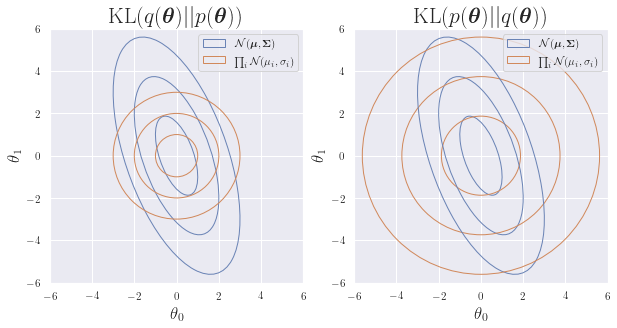

In [38]:
mu = [0, 0]
cov = np.array([[1, -1], [-1, 3.5]])
cov1 = np.eye(2) * cov[0,0]
cov2 = np.eye(2) * cov[1,1]

fig, axs = plt.subplots(1, 2, figsize=(10,5))

for ax, cov_vi in zip(axs, [cov1, cov2]):
    for n_std in np.arange(0, 4, 1):
        ell_true = confidence_ellipse(mu, cov, ax, n_std=n_std, edgecolor='#6A83B5')
        ell_vi = confidence_ellipse(mu, cov_vi, ax, n_std=n_std, edgecolor='#D1895C')

for ax, title in zip(axs, [r'$\mathrm{KL}(q(\bm{\theta})||p(\bm{\theta}))$', 
                           r'$\mathrm{KL}(p(\bm{\theta})||q(\bm{\theta}))$']):
    ax.set_ylim([-6, 6])
    ax.set_xlim([-6, 6])
    ax.set_xlabel(r'$\theta_0$', fontsize=17)
    ax.set_ylabel(r'$\theta_1$', fontsize=17)
    ax.set_title(title, fontsize=22)
    ax.set_aspect(1)
    ax.legend([ell_true, ell_vi], [r'$\mathcal{N}(\bm{\mu},\bm{\Sigma})$', 
                                   r'$\prod_i \mathcal{N}(\mu_i,\sigma_i)$'])

### Bayesian Linear Regression with Variational Inference

We perform Bayesian linear regression on the same model already used in the blog post about <a href="https://maltetoelle.github.io/linear/regression/2020/10/27/try.html">Bayesian linear regression</a> using Bayes theorem. Recall the likelihood for our observed target variables $\mathbf{y}$ and the prior distribution for our model parameters $\boldsymbol{\theta}$ are given by

$$
\begin{aligned}
p(\mathbf{y}|\boldsymbol{\theta}) &= \prod_{n=1}^{N} \mathcal{N}\left( y_n | \boldsymbol{\theta}^T \Phi_n, \beta^{-1} \right) ~, \\
p(\boldsymbol{\theta}|\alpha) &= \mathcal{N}\left( \mathbf{0},\alpha^{-1}\mathbf{I}_{M+1} \right) ~,
\end{aligned}
$$

with $\Phi_n=\Phi(x_n)=(x_n^0,x_n^1,...,x_n^{M})^T$ where $M$ denotes the degree of the fitted polynomial and $\mathbf{I}_{M+1}$ denotes the identity matrix of size $M+1$. We now introduce prior distributions over $\alpha$ and $\beta$. The conjugate prior for Gaussian distributions is the Wishart distribution or in the one dimensional case the Gamme distribution:

$$
\begin{aligned}
p(\alpha) &= \textrm{Gam}(\alpha|a_0,b_0) ~, \\
p(\beta) &= \textrm{Gam}(\beta|c_0,d_0) ~.
\end{aligned}
$$

The definition of the Gamma and log Gamma distribution can be found in the appendix at the end of the post. Thus, the joint distribution of all the variables is given by

$$
p(\mathbf{y},\boldsymbol{\theta},\alpha,\beta) = p(\mathbf{y}|\boldsymbol{\theta},\beta) p(\boldsymbol{\theta}|\alpha) p(\beta) p(\alpha) ~.
$$

By using the mean field approximation the approximation of the posterior $p(\boldsymbol{\theta},\alpha,\beta)$ is given by the factorization

$$
q(\boldsymbol{\theta},\alpha,\beta)=q(\boldsymbol{\theta})q(\alpha)q(\beta) ~.
$$

We can find the optimal variational parameters for each of the above distributions by making use of Eq. $\eqref{eq:optimal_var_params}$. For each factor, we take the log of the joint distribution over all variables and then average w.r.t. to those variables not in the factor.

#### Variational density for $\alpha$

The log of our optimal variational density $q^*(\alpha)$ is given by

$$
\begin{aligned}
\log q^*(\alpha) &= \log p(\alpha) + \mathbb{E}\left[ \log p(\boldsymbol{\theta}|\alpha) \right] + \mathcal{Z} \\
&= (a_0 - 1) \log a - b_0 \alpha + \frac{M}{2} \log \alpha - \frac{\alpha}{2} \mathbb{E} \left[ \boldsymbol{\theta}^T \boldsymbol{\theta} \right] + \mathcal{Z} ~.
\end{aligned}
$$

We notice the above as the parameters of a log Gamma distribution, so we can perform coefficient comparison and find the optimal variational distribution for $\alpha$ to be

$$
q^*(\alpha) = \textrm{Gam}(\alpha|a_N,b_N) ~,
$$

where

$$
\begin{aligned}
a_N &= a_0 + \frac{M}{2} ~, \\
b_N &= b_0 + \frac{1}{2}\mathbb{E}\left[ \boldsymbol{\theta}^T\boldsymbol{\theta} \right] ~.
\end{aligned}
$$

#### Variational density for $\boldsymbol{\theta}$

Similarly, the log of our optimal variational density $q^*(\theta)$ is given by

$$
\begin{aligned}
\log q^*(\boldsymbol{\theta}) &= \mathbb{E}_{\beta}\left[ \log p(\mathbf{y}|\boldsymbol{\theta},\beta) \right] + \mathbb{E}_{\alpha}\left[ p(\boldsymbol{\theta}|\alpha) \right] + \mathcal{Z} \\
&\propto -\frac{\mathbb{E}_{\beta}}{2} \sum_{n=1}^{N}\left( y_n - \boldsymbol{\theta}^T\Phi_n \right)^2 - \frac{\mathbb{E}_{\alpha}}{2} \boldsymbol{\theta}^T\boldsymbol{\theta} + \mathcal{Z} \\
&\propto -\frac{\mathbb{E}_{\beta}}{2} \sum_{n=1}^{N} \left\{-2\boldsymbol{\theta}^T\Phi_n y_n + \left(\boldsymbol{\theta}^T\Phi_n\right)^2 \right\} - \frac{\mathbb{E}_{\alpha}}{2} \boldsymbol{\theta}^T\boldsymbol{\theta} + \mathcal{Z} \\
&= -\frac{1}{2} \boldsymbol{\theta}^T \left\{ \mathbb{E}_{\beta} \boldsymbol{\Phi}^T\boldsymbol{\Phi} + \mathbb{E}_{\alpha}\mathbf{I} \right\} \boldsymbol{\theta} + \mathbb{E}_{\beta}\boldsymbol{\theta}^T\boldsymbol{\Phi}^T\mathbf{y} + \mathcal{Z} ~.
\end{aligned}
$$

We recognize this as a log normal distribution and find our coefficients to be

$$
q^*(\boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{\theta}|\mathbf{m}_N,\mathbf{S}_N) ~,
$$

where

$$
\begin{aligned}
\mathbf{m}_N &= \mathbb{E}_{\beta} \mathbf{S}_N \boldsymbol{\Phi}^T \mathbf{y} ~, \\
\mathbf{S}_N &= \left( \mathbb{E}_{\beta}\boldsymbol{\Phi}^T\boldsymbol{\Phi} + \mathbb{E}_{\alpha} \mathbf{I} \right)^{-1} ~.
\end{aligned}
$$

#### Variational Density for $\beta$

As for $\alpha$ and $\boldsymbol{\theta}$, the optimal variational density $q^*(\beta)$ is given by

$$
\begin{aligned}
\log q^*(\beta) &= \log p(\beta) + \mathbb{E}_{\boldsymbol{\theta}}\left[ \log p(\mathbf{y}|\boldsymbol{\theta},\beta) \right] + \mathcal{Z} \\
&\propto (c_0 - 1)\log \beta - d_0\beta + \frac{N}{2} \log \beta - \frac{\beta}{2} \mathbb{E} \left[ \sum_{n=1}^{N} \left( y_n - \boldsymbol{\theta}^T\Phi_n \right)^2 \right] + \mathcal{Z} \\
&= \left( \frac{N}{2} + c_0 - 1 \right)\log\beta - d_0\beta - \frac{\beta}{2} \mathbb{E}\left[ \mathbf{y}^T\mathbf{y} -2\boldsymbol{\theta}\boldsymbol{\Phi} \mathbf{y} + \boldsymbol{\theta}^T\boldsymbol{\Phi}^T\boldsymbol{\Phi}\boldsymbol{\theta} \right] + \mathcal{Z} \\
&= \left( \frac{N}{2} + c_0 - 1 \right)\log\beta -\beta \left\{ d_0 + \frac{1}{2}\mathrm{Tr}\left[ \boldsymbol{\Phi}^T\boldsymbol{\Phi}\, \mathbb{E}\left[ \boldsymbol{\theta}^T\boldsymbol{\theta} \right] \right] - \mathbb{E}\left[ \boldsymbol{\theta}^T \right] \boldsymbol{\Phi}\mathbf{y} + \frac{1}{2}\mathbf{y}^T\mathbf{y} \right\} + \mathcal{Z} \\
&= \left( \frac{N}{2} + c_0 - 1 \right)\log\beta -\beta \left\{ d_0 + \frac{1}{2}\mathrm{Tr}\left[ \boldsymbol{\Phi}^T\boldsymbol{\Phi}\left( \mathbf{m}_N\mathbf{m}_N^T + \mathbf{S}_N \right) \right] - \mathbf{y}^T\boldsymbol{\Phi}\mathbf{m}_N + \frac{1}{2}\mathbf{y}^T\mathbf{y} \right\} + \mathcal{Z} \\
&= \left( \frac{N}{2} + c_0 - 1 \right)\log\beta -\beta \left\{ d_0 + \frac{1}{2}\mathrm{Tr}\left[ \boldsymbol{\Phi}^T\boldsymbol{\Phi}\mathbf{S}_N \right] + \frac{1}{2}\mathbf{m}_N^T\boldsymbol{\Phi}^T\boldsymbol{\Phi}\mathbf{m}_N - \mathbf{y}^T\boldsymbol{\Phi}\mathbf{m}_N + \frac{1}{2}\mathbf{y}^T\mathbf{y} \right\} + \mathcal{Z} \\
&= \left( \frac{N}{2} + c_0 - 1 \right)\log\beta -\frac{\beta}{2} \left\{ 2d_0 + \mathrm{Tr}\left[ \boldsymbol{\Phi}^T\boldsymbol{\Phi}\mathbf{S}_N \right] + \sum_{n=1}^{N}\left( y_n - \mathbf{m}_N^T\Phi_n \right)^2 \right\} + \mathcal{Z} ~.
\end{aligned}
$$

We again recognize this as the coefficients of a log Gamma distribution

$$
q^*(\beta) = \textrm{Gam}(\beta|c_N,d_N) ~,
$$

where

$$
\begin{aligned}
c_N &= \frac{N}{2} + c_0 ~, \\
d_N &= d_0 + \frac{1}{2} \left\{ \mathrm{Tr}\left[ \boldsymbol{\Phi}^T\boldsymbol{\Phi}\mathbf{S}_N \right] + \sum_{n=1}^{N} \left( y_n - \mathbf{m}_N^T\Phi_n \right)^2 \right\} ~.
\end{aligned}
$$

#### Estimating the Missing Moments

The missing moments of the Gamma distributions for $\alpha$ and $\beta$ can be easily estimated from the definition of the distribution.

$$
\begin{aligned}
\mathbb{E}[\alpha] &= \frac{a_N}{b_N} \\
&= \frac{a_0 + \frac{M}{2}}{b_0 + \frac{1}{2}\mathbb{E}\left[ \boldsymbol{\theta}^T\boldsymbol{\theta} \right]}\\
&= \frac{a_0 + \frac{M}{2}}{b_0 + \frac{1}{2}\mathbf{m}_N^T\mathbf{m}_N + \textrm{Tr}(\mathbf{S}_N)} \quad \textrm{with} \quad \mathbb{E}\left[ \boldsymbol{\theta}\boldsymbol{\theta}^T \right] = \mathbf{m}_N\mathbf{m}_N^T + \mathbf{S}_N ~, \\
\mathbb{E}[\beta] &= \frac{c_N}{d_N} \\
&= \frac{\frac{N}{2} + c_0}{d_0 + \frac{1}{2} \left\{ \mathrm{Tr}\left[ \boldsymbol{\Phi}^T\boldsymbol{\Phi}\mathbf{S}_N \right] + \sum_{n=1}^{N} \left( y_n - \mathbf{m}_N^T\Phi_n \right)^2 \right\}}
\end{aligned}
$$

VI for linear regression is performed by cyclically estimating the parameters $a_N$, $b_N$, $c_N$, $d_N$, $\mathbf{m}_N$, and $\mathbf{S}_N$ with the corresponding update formulas. Which can be done in a small number of lines in code compared to the long derivations above. But before we take a look at the code, we must examine the predictive distribution of the model.

#### Predictive Distribution

The predictive distribution for new data points $(\mathbf{x}_*,\mathbf{y}_*)$ can easily be evaluated using the Gaussian variational posterior for the parameters

$$
\begin{aligned}
p(\mathbf{y}_*|\mathbf{x}_*,\mathbf{y}) &= \int p(\mathbf{y}_*|\mathbf{x}_*,\boldsymbol{\theta})p(\boldsymbol{\theta}|\mathbf{y})\,d\boldsymbol{\theta} \\
&= \int p(\mathbf{y}_*|\mathbf{x}_*,\boldsymbol{\theta})q(\boldsymbol{\theta})\,d\boldsymbol{\theta} \\
&= \int\mathcal{N}\left( \mathbf{y}_*|\boldsymbol{\theta}^T\boldsymbol{\Phi}(\mathbf{x}_*), \mathbb{E}[\beta] \right) \mathcal{N}\left( \boldsymbol{\theta} | \mathbf{m}_N,\mathbf{S}_N \right)\,d\boldsymbol{\theta} \\
&= \mathcal{N}\left( \mathbf{m}_N^T\boldsymbol{\Phi}(\mathbf{x}_*),\sigma^2(\mathbf{x}_*) \right) \quad \textrm{with} \quad \sigma^2(\mathbf{x}_*) = \frac{1}{\mathbb{E}[\beta]} + \boldsymbol{\Phi}(\mathbf{x}_*)^T \mathbf{S}_N \boldsymbol{\Phi}(\mathbf{x}_*) ~.
\end{aligned}
$$

In [27]:
class VI:
    def __init__(self, num_iter: int = 100, start_alpha: float = 0.1, start_beta: float = 0.1,
                 a0: float = 0., b0: float = 0., c0: float = 0., d0: float = 0.):
        
        # initializing all with 0 corresponds to an infinitely wide prior
        self.a0 = a0
        self.b0 = b0
        self.c0 = c0
        self.d0 = d0

        self.alpha = start_alpha
        self.beta = start_beta

        self.num_iter = num_iter
    
    def training(self, x, y, pol_grad: int = 1):
        self.D = pol_grad + 1
        N = len(y)
        X = np.array([x**k for k in range(self.D)]).transpose()
        
        aN = self.a0 + self.D/2 
        cN = self.c0 + N/2
        
        for i in tqdm(range(self.num_iter)):
            self.SN = np.linalg.inv(self.beta * X.T @ X + self.alpha * np.eye(self.D))
            
            self.mN = self.beta * self.SN @ X.T @ y
            
            dN = self.d0 + 0.5 * ((y - X @ self.mN)**2).sum() + 0.5 * np.trace(X.T @ X @ self.SN)
            self.beta = cN/dN
            
            bN = self.b0 + 0.5 * self.mN.T @ self.mN + np.trace(self.SN)
            self.alpha = aN/bN
        
        # estimated variance in the training data
        self.x_var = (1/self.beta) + X @ self.SN @ X.T
        
        return self.mN, self.SN
    
    def posterior_pred(self, x_pred):
        X = np.array([x_pred**k for k in range(self.D)]).transpose()
        
        #mean = X @ self.mN
        #var = np.array([1/self.beta + x @ self.SN @ x.T for x in X])
        
        preds = []
        for _ in range(100):
            #pred = np.random.normal(mean, np.sqrt(var))
            weight_sample = np.random.multivariate_normal(self.mN, self.SN)
            pred = X @ weight_sample[:,np.newaxis]
            preds.append(pred)
        preds = np.array(preds)
        return preds.mean(axis=0).flatten(), preds.std(axis=0).flatten()

In [5]:
start_params_mcmc = np.array([0.5, 0.5, 0.5])
mcmc = MCMC(start_params=start_params_mcmc, model=model)
posterior_params_mcmc = mcmc.metropolis_hastings(x, y_noisy)

100%|██████████| 9999/9999 [00:16<00:00, 608.69it/s]


In [30]:
vi = VI(num_iter=1000)
w_mean_vi, w_cov_vi = vi.training(x, y_noisy)

100%|██████████| 1000/1000 [00:00<00:00, 2680.90it/s]


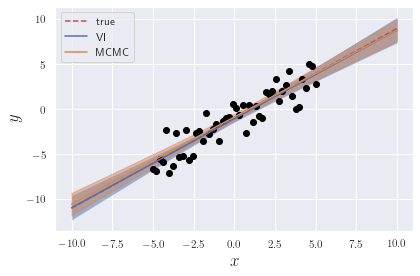

In [31]:
x_pred = np.linspace(-10, 10, 1000)

y_true_pred = model(x_pred, weights)

y_pred_mcmc_mean, y_pred_mcmc_std = mcmc.posterior_pred(x_pred)
y_pred_vi_mean, y_pred_vi_std = vi.posterior_pred(x_pred)

plt.plot(x_pred, y_true_pred, color='r', linestyle='--', label='true')
plt.plot(x_pred, y_pred_vi_mean, label='VI')
plt.fill_between(x_pred, y_pred_vi_mean + 2 * y_pred_vi_std, y_pred_vi_mean - 2 * y_pred_vi_std, alpha=0.5)
plt.plot(x_pred, y_pred_mcmc_mean, label='MCMC', color='#D1895C')
plt.fill_between(x_pred, y_pred_mcmc_mean + 2 * y_pred_mcmc_std, y_pred_mcmc_mean - 2 * y_pred_mcmc_std, color='#D1895C', alpha=0.5)
plt.scatter(x, y_noisy, color='black')
plt.legend()
plt.xlabel(r'$x$', fontsize=17)
plt.ylabel(r'$y$', fontsize=17)
plt.tight_layout()
#plt.savefig('reg_mcmc_vi.png', bbox_inches='tight')
plt.show()

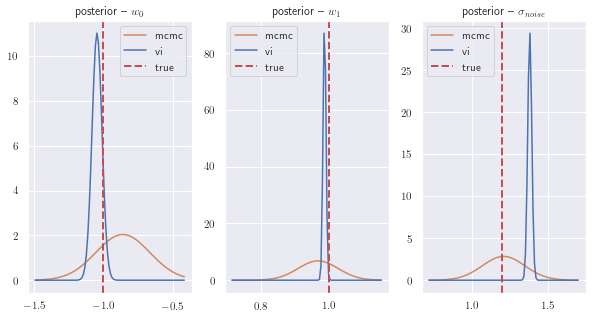

In [32]:
fig, axs = plt.subplots(1, mcmc.chain.shape[1], figsize=(10,5))
for i, ax in enumerate(axs):
    # mcmc
    samples = mcmc.chain[mcmc.burnin_iter-1:,i]
    x_w_viz = np.linspace(samples.min(), samples.max(), 100)
    
    mu_mcmc, std_mcmc = stats.norm.fit(samples)
    
    if i != len(axs)-1:
        # mcmc
        ax.plot(x_w_viz, stats.norm.pdf(x, mu_mcmc, std_mcmc), label='mcmc', color='#D1895C')
        # vi
        ax.plot(x_w_viz, stats.norm.pdf(x, vi.mN[i], vi.SN[i,i]), label='vi')
        ax.axvline(weights[i], color='r', linestyle='--', linewidth=2, label='true')
        ax.title.set_text(r'posterior -- $w_%d$' % i)
    else:
        vi_std_mean = np.sqrt(vi.x_var.mean())
        vi_std_std = np.sqrt(vi.x_var).std()
        new_x = np.linspace(mu_mcmc-3.5*std_mcmc, mu_mcmc+3.5*std_mcmc, 100)
        # mcmc
        ax.plot(new_x, stats.norm.pdf(new_x, mu_mcmc, std_mcmc), label='mcmc', color='#D1895C')
        # vi
        ax.plot(new_x, stats.norm.pdf(new_x, vi_std_mean, vi_std_std), label='vi')

        ax.axvline(std_noise, color='r', linestyle='--', linewidth=2, label='true')
        ax.title.set_text(r'posterior -- $\sigma_{noise}$')
    ax.legend()
plt.show()

## Appendix

### (Log) Gamma distribution

$$
\begin{aligned}
\textrm{Gam}(x|a,b) &= \frac{1}{\Gamma (a)} b^{a} x^{a-1} e^{-bx} \\
&= \frac{1}{(a-1)!} b^{a} x^{a-1} e^{-bx} \\
\log \textrm{Gam}(x|a,b) &= \underbrace{-\log\left((a-1)!\right) + a\log b}_{\textrm{const. w.r.t. }x} + (a-1)\log x - bx
\end{aligned}
$$

In [11]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

#def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', edgecolor='black', **kwargs):
def confidence_ellipse(mu, cov, ax, n_std=3.0, facecolor='none', edgecolor='black', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    From: https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    #if x.size != y.size:
    #    raise ValueError("x and y must be the same size")

    #cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, edgecolor=edgecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(mu[0])

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(mu[1])

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)